# Introduction to Dataset 

The dataset consists of 10 000 data points stored as rows with 14 features in columns
UID: unique identifier ranging from 1 to 10000
product ID: consisting of a letter L, M, or H for low (50% of all products), medium (30%) and high (20%) as product quality variants and a variant-specific serial number
air temperature [K]: generated using a random walk process later normalized to a standard deviation of 2 K around 300 K
process temperature [K]: generated using a random walk process normalized to a standard deviation of 1 K, added to the air temperature plus 10 K.
rotational speed [rpm]: calculated from a power of 2860 W, overlaid with a normally distributed noise
torque [Nm]: torque values are normally distributed around 40 Nm with a Ïƒ = 10 Nm and no negative values. 
tool wear [min]: The quality variants H/M/L add 5/3/2 minutes of tool wear to the used tool in the process. and a
'machine failure' label that indicates, whether the machine has failed in this particular datapoint for any of the following failure modes are true.

The machine failure consists of five independent failure modes
tool wear failure (TWF): the tool will be replaced of fail at a randomly selected tool wear time between 200 â€“ 240 mins (120 times in our dataset). At this point in time, the tool is replaced 69 times, and fails 51 times (randomly assigned).
heat dissipation failure (HDF): heat dissipation causes a process failure, if the difference between air- and process temperature is below 8.6 K and the toolâ€™s rotational speed is below 1380 rpm. This is the case for 115 data points.
power failure (PWF): the product of torque and rotational speed (in rad/s) equals the power required for the process. If this power is below 3500 W or above 9000 W, the process fails, which is the case 95 times in our dataset.
overstrain failure (OSF): if the product of tool wear and torque exceeds 11,000 minNm for the L product variant (12,000 M, 13,000 H), the process fails due to overstrain. This is true for 98 datapoints.
random failures (RNF): each process has a chance of 0,1 % to fail regardless of its process parameters. This is the case for only 5 datapoints, less than could be expected for 10,000 datapoints in our dataset.

If at least one of the above failure modes is true, the process fails and the 'machine failure' label is set to 1. It is therefore not transparent to the machine learning method, which of the failure modes has caused the process to fail 

# Business Understanding




1.   *Determine if the machine will failure*
2.   *Determine the type of failure*


# Data Understanding

In [471]:
# Data wrangling
import pandas as pd

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px


#Resampling
from imblearn.over_sampling import SMOTENC

#Dimension Reduction
from sklearn.decomposition import PCA

# Preprocessing
from sklearn.preprocessing import StandardScaler, PowerTransformer, OrdinalEncoder, OneHotEncoder

# Models
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Models Pipelines
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Model evaluation
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, balanced_accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelBinarizer

# Save model
import pickle


In [406]:
## Upload df
df = pd.read_csv(r'C:\Users\eng.fitness69\Documents\predictive_maintenance\predictive_maintenance.csv')
df

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure
...,...,...,...,...,...,...,...,...,...,...
9995,9996,M24855,M,298.8,308.4,1604,29.5,14,0,No Failure
9996,9997,H39410,H,298.9,308.4,1632,31.8,17,0,No Failure
9997,9998,M24857,M,299.0,308.6,1645,33.4,22,0,No Failure
9998,9999,H39412,H,299.0,308.7,1408,48.5,25,0,No Failure


In [407]:
# Verify if the data has duplicate values or null values.
data_duplicates = df.duplicated().sum()
data_null = df.isnull().sum().sum()

print("Total de dados duplicados: ", data_duplicates)
print("Total de dados faltantes/nulos: ", data_null)

Total de dados duplicados:  0
Total de dados faltantes/nulos:  0


In [408]:
## Verify the data structure
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Target                   10000 non-null  int64  
 9   Failure Type             10000 non-null  object 
dtypes: float64(3), int64(4), object(3)
memory usage: 781.4+ KB


In [409]:
## Numeric features analysis
df.describe()

,UDI,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,5000.50000,300.004930,310.005560,1538.776100,39.986910,107.951000,0.033900
std,2886.89568,2.000259,1.483734,179.284096,9.968934,63.654147,0.180981
min,1.00000,295.300000,305.700000,1168.000000,3.800000,0.000000,0.000000
25%,2500.75000,298.300000,308.800000,1423.000000,33.200000,53.000000,0.000000
50%,5000.50000,300.100000,310.100000,1503.000000,40.100000,108.000000,0.000000
75%,7500.25000,301.500000,311.100000,1612.000000,46.800000,162.000000,0.000000
max,10000.00000,304.500000,313.800000,2886.000000,76.600000,253.000000,1.000000


In [410]:
## Verify the proportion of column "Target"
df.Target.value_counts()

0    9661
1     339
Name: Target, dtype: int64

In [411]:
## Verify the proportion of column "Failure_type"
df['Failure Type'].value_counts()

No Failure                  9652
Heat Dissipation Failure     112
Power Failure                 95
Overstrain Failure            78
Tool Wear Failure             45
Random Failures               18
Name: Failure Type, dtype: int64

How can be see, we dont have proportion in the column "Failure_type" distribution

# Data Preparation


In [412]:
## Rename the columns (dont needed, but i like change for my custom)

rename_columns = {
    
    'UDI':'ID',
    'Air temperature [K]': 'Air_temperature',
    'Process temperature [K]' : 'Process_temperature',
    'Rotational speed [rpm]' : 'Rotational_speed',
    'Torque [Nm]' : 'Torque',
    'Tool wear [min]' : 'Tool_wear',
    'Product ID' : 'Product_ID',
    'Failure Type': 'Failure_type'    
    
}

df.rename(rename_columns, axis = 1, inplace = True)

In [413]:
## Regarding to introduction of dataset, we don't need ID and Product_ID columns for us business objective, so lets remove this.

drop_columns = ["ID", "Product_ID"]

df.drop(drop_columns, axis = 1, inplace = True)

In [414]:
## Change de type of "Rotational_speed" and "Tool_wear" columns to "float"
df['Rotational_speed'] = df['Rotational_speed'].astype('float')
df['Tool_wear'] = df['Tool_wear'].astype('float')


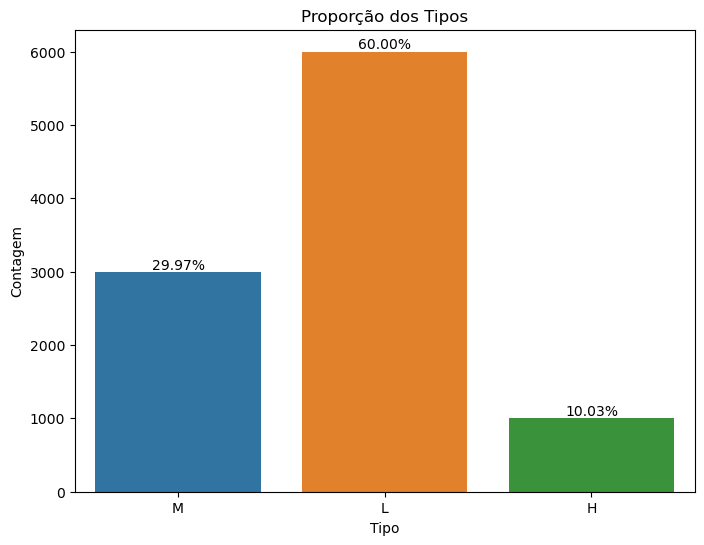

In [415]:
# Count types
tipo_contagem = df['Type'].value_counts()

# Show graphic
plt.figure(figsize=(8, 6))
ax = sns.countplot(data=df, x='Type')
plt.title('Proporção dos Tipos')
plt.xlabel('Tipo')
plt.ylabel('Contagem')

# Add as percentages as labels
total = len(df['Type'])
for p in ax.patches:
    height = p.get_height()
    percentage = (height / total) * 100
    ax.annotate(f'{percentage:.2f}%', (p.get_x() + p.get_width() / 2, height),
                ha='center', va='bottom')

plt.show()

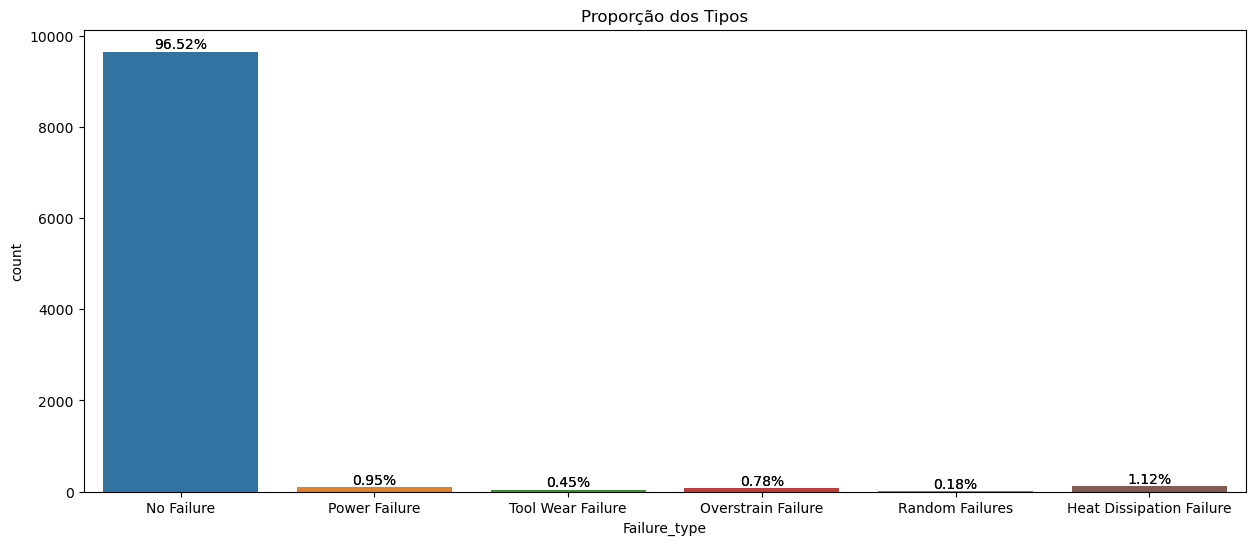

In [416]:
# Count types
tipo_contagem = df['Failure_type'].value_counts()

# Plot bar graphic
plt.figure(figsize=(15, 6))
ax = sns.countplot(data=df, x='Failure_type')
plt.title('Proporção dos Tipos')
plt.xlabel('Tipo')
plt.ylabel('Contagem')

ax = sns.countplot(data=df, x = 'Failure_type')

# Add as percentages as labels
total = len(df['Failure_type'])
for p in ax.patches:
    height = p.get_height()
    percentage = (height / total) * 100
    ax.annotate(f'{percentage:.2f}%', (p.get_x() + p.get_width() / 2, height),
                ha='center', va='bottom')

plt.show()

How i've mencioned , we have a problem with this target column, the column hasn't proporcional distribution and has only "Random Failures", so i will delete this and i need apply the over sampling - Smote in the rest of df.

In [417]:
df.drop(df[df['Failure_type'] == 'Random Failures'].index, inplace=True)

In [418]:
# count failures on "Target" column
count_failures = (df['Target'] == 1).sum()
print('Número de falhas:', count_failures)

# Sum of occurrences of 'Failure_type' other than 'No Failure'
sum_failures = df.loc[(df['Failure_type'] != 'No Failure') & (df['Target'] == 1), 'Failure_type'].count()
print('Soma das falhas de tipo diferente de "No Failure":', sum_failures)

Número de falhas: 339
Soma das falhas de tipo diferente de "No Failure": 330


In [419]:
##9 data is ambiguous, so we need remove this.

# Filter the rows with has 1 in the column "Target" and 'No Failure' in the column 'Failure_type'
rows_to_remove = df[(df['Target'] == 1) & (df['Failure_type'] == 'No Failure')]

# Remove this filtered row in the main df
df.drop(rows_to_remove.index, inplace=True)

In [420]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9973 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Type                 9973 non-null   object 
 1   Air_temperature      9973 non-null   float64
 2   Process_temperature  9973 non-null   float64
 3   Rotational_speed     9973 non-null   float64
 4   Torque               9973 non-null   float64
 5   Tool_wear            9973 non-null   float64
 6   Target               9973 non-null   int64  
 7   Failure_type         9973 non-null   object 
dtypes: float64(5), int64(1), object(2)
memory usage: 701.2+ KB


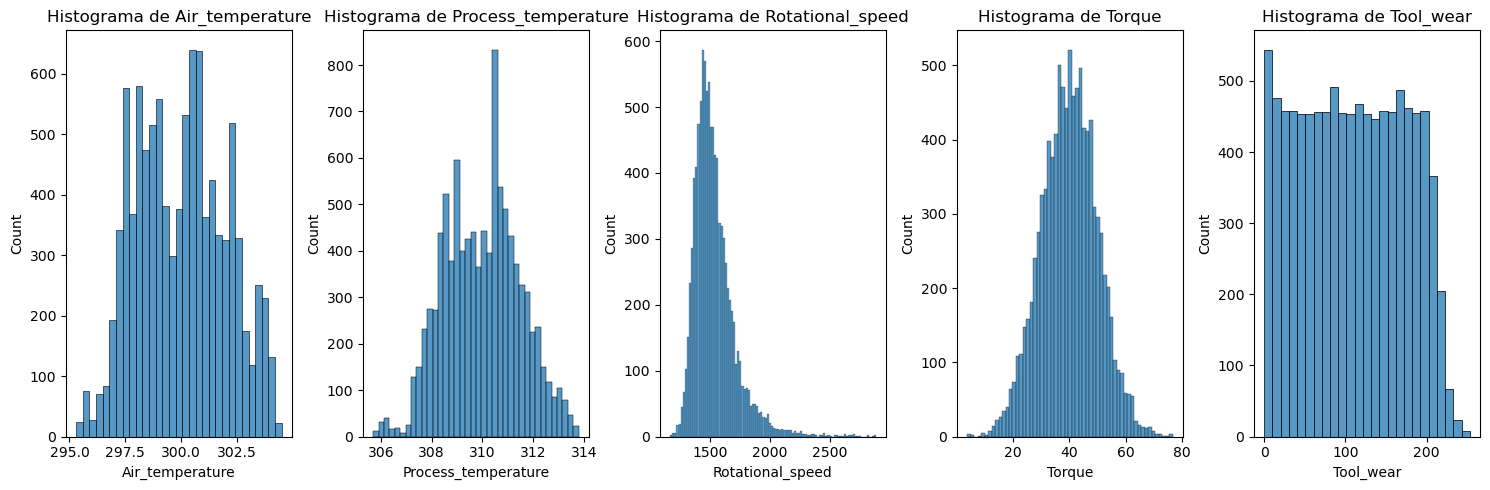

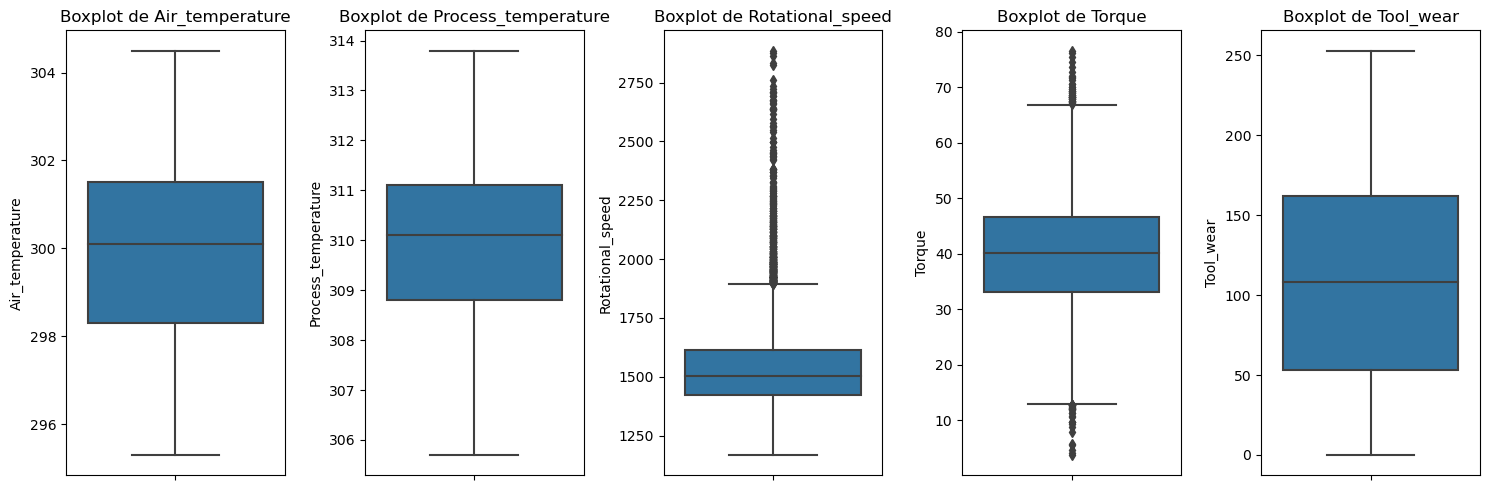

In [421]:
NUMERIC_FEATURES = ['Air_temperature', 'Process_temperature', 'Rotational_speed', 'Torque', 'Tool_wear']
CATEGORIC_FEATURES = ['Type']

# Create the figure and axes
fig, axes = plt.subplots(nrows=1, ncols=len(NUMERIC_FEATURES), figsize=(15, 5))

# Plot histograms 
for i, feature in enumerate(NUMERIC_FEATURES):
    sns.histplot(data=df, x=feature, ax=axes[i])
    axes[i].set_title(f'Histograma de {feature}')

# Adjust subplot 
plt.tight_layout()

# Show histogram 
plt.show()

# Create the figure and axess
fig, axes = plt.subplots(nrows=1, ncols=len(NUMERIC_FEATURES), figsize=(15, 5))

# Plot boxplot side by side
for i, feature in enumerate(NUMERIC_FEATURES):
    sns.boxplot(data=df, y=feature, ax=axes[i])
    axes[i].set_title(f'Boxplot de {feature}')

# Adjust subplot
plt.tight_layout()

# Show boxplots
plt.show()



How can i see, maybe we have some outliers in the "Rotational_speed" and "Torque" columns, but we cant remove this now. Its necessary avaliate better.

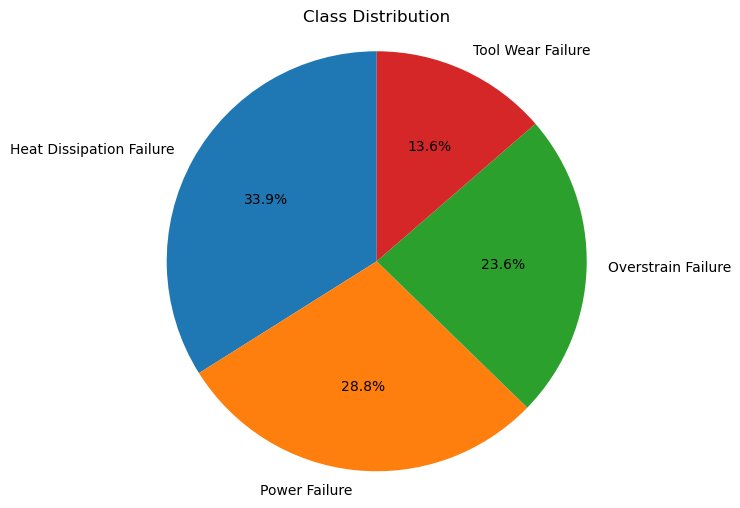

In [473]:
df_failure_type = df.loc[df['Failure_type'] != "No Failure"]
# Verifique o balanceamento resultante
proportions = df_failure_type['Failure_type'].value_counts(normalize=True)


# Plotar o gráfico de pizza
plt.figure(figsize=(8, 6))
plt.pie(proportions, labels=proportions.index, autopct='%1.1f%%', startangle=90)
plt.axis('equal')  # Assegura que o gráfico seja desenhado como um círculo
plt.title('Class Distribution')
plt.show()

In [423]:
# n_working must represent 80% of the desired length of resampled dataframe
qtd_no_failures_main = df['Failure_type'].value_counts()['No Failure']
qtd_no_failures = round(qtd_no_failures_main/0.8)
qtd_all_failures = round((qtd_no_failures-qtd_no_failures_main)/5)  #samples per class
# Resampling
dist ={
    'No Failure':qtd_no_failures_main,
    'Overstrain Failure':qtd_all_failures,
    'Heat Dissipation Failure':qtd_all_failures,
    'Power Failure':qtd_all_failures,
    'Tool Wear Failure':qtd_all_failures
}
sm = SMOTENC(categorical_features=[0,7], sampling_strategy=dist, random_state=0)
df_res, y_res = sm.fit_resample(df, df['Failure_type'])

In [424]:
df_res.Failure_type.value_counts(normalize=True)


No Failure                  0.833377
Power Failure               0.041656
Tool Wear Failure           0.041656
Overstrain Failure          0.041656
Heat Dissipation Failure    0.041656
Name: Failure_type, dtype: float64

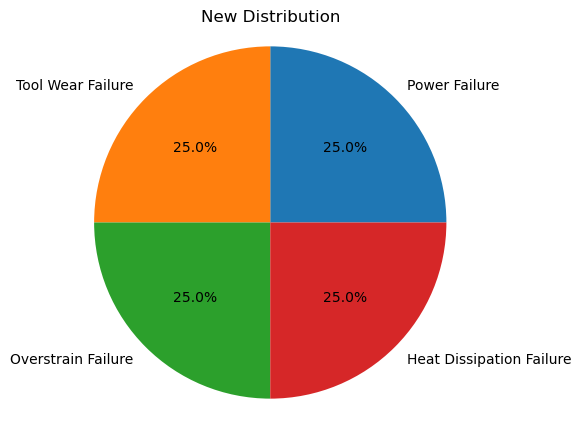

In [425]:
df_new_dist = df_res.loc[df_res['Failure_type'] != "No Failure"]
view_new_dist = df_new_dist.Failure_type.value_counts(normalize = True)
plt.figure(figsize = (5,5))
plt.pie(view_new_dist, labels = view_new_dist.index, autopct='%1.1f%%' )
plt.title("New Distribution")
plt.axis('equal');

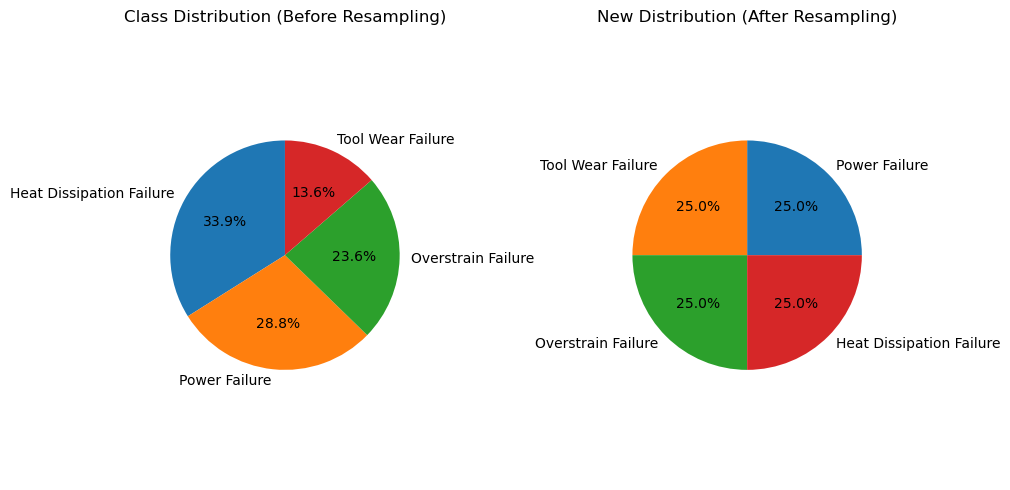

In [472]:
import matplotlib.pyplot as plt
plt.figure(figsize = (10,5))
# Before resampling
plt.subplot(1, 2, 1)  # create the subplot on left
plt.pie(proportions, labels=proportions.index, autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('Class Distribution (Before Resampling)')

# after do Resampling
plt.subplot(1, 2, 2)  # create the subplot on right
plt.pie(view_new_dist, labels=view_new_dist.index, autopct='%1.1f%%')
plt.axis('equal')
plt.title('New Distribution (After Resampling)')

plt.tight_layout()  # Adjust automaticaly the spaces between the subplots
plt.show()


Great! Now i've a proportional distribution. Lets see if we can reduce dimension with PCA analysis.

In [429]:
sc = StandardScaler()
type_dict = {'L': 0, 'M': 1, 'H': 2}
cause_dict = {'No Failure': 0,
              'Power Failure': 1,
              'Overstrain Failure': 2,
              'Heat Dissipation Failure': 3,
              'Tool Wear Failure': 4}
df_pre = df_res.copy()
# Encoding
df_pre['Type'].replace(to_replace=type_dict, inplace=True)
df_pre['Failure_type'].replace(to_replace=cause_dict, inplace=True)
# Scaling
df_pre[NUMERIC_FEATURES] = sc.fit_transform(df_pre[NUMERIC_FEATURES]) 
df_main = df_pre.copy()

In [430]:
from sklearn.compose import make_column_transformer
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split

NUMERICS_FEATURES = [
    'Air_temperature',
    'Process_temperature',
    'Rotational_speed',
    'Torque',
    'Tool_wear'
]

FEATURES = NUMERICS_FEATURES
TARGET = ['Failure_type']
X = df_main[FEATURES]
y = df_main[TARGET]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, stratify=y, random_state=2023)

preprocessor = make_column_transformer(
    (StandardScaler(), NUMERICS_FEATURES),
    remainder='passthrough'  
)

pca = PCA(n_components=len(NUMERICS_FEATURES))

model_pipeline = make_pipeline(
    preprocessor,
    pca,
    DummyClassifier()
)

model_pipeline.fit(X_train, y_train)

# Getting the principal components
pca_components = model_pipeline.named_steps['pca'].components_

# Getting the variances explained
explained_variance_ratio = model_pipeline.named_steps['pca'].explained_variance_ratio_

# Creating the Explained Variance DataFrame
variance_df = pd.DataFrame(explained_variance_ratio, columns=['Explained Variance'])
variance_df['Component'] = ['Component ' + str(i+1) for i in range(len(explained_variance_ratio))]

# Show DataFrame
print(variance_df)

   Explained Variance    Component
0            0.376024  Component 1
1            0.369075  Component 2
2            0.198497  Component 3
3            0.030743  Component 4
4            0.025661  Component 5


How can we see, with 3 componente 94,2% is explained so the others 2 will be desconsidered. Lets see the first 3 components with bar graphics to better understand.

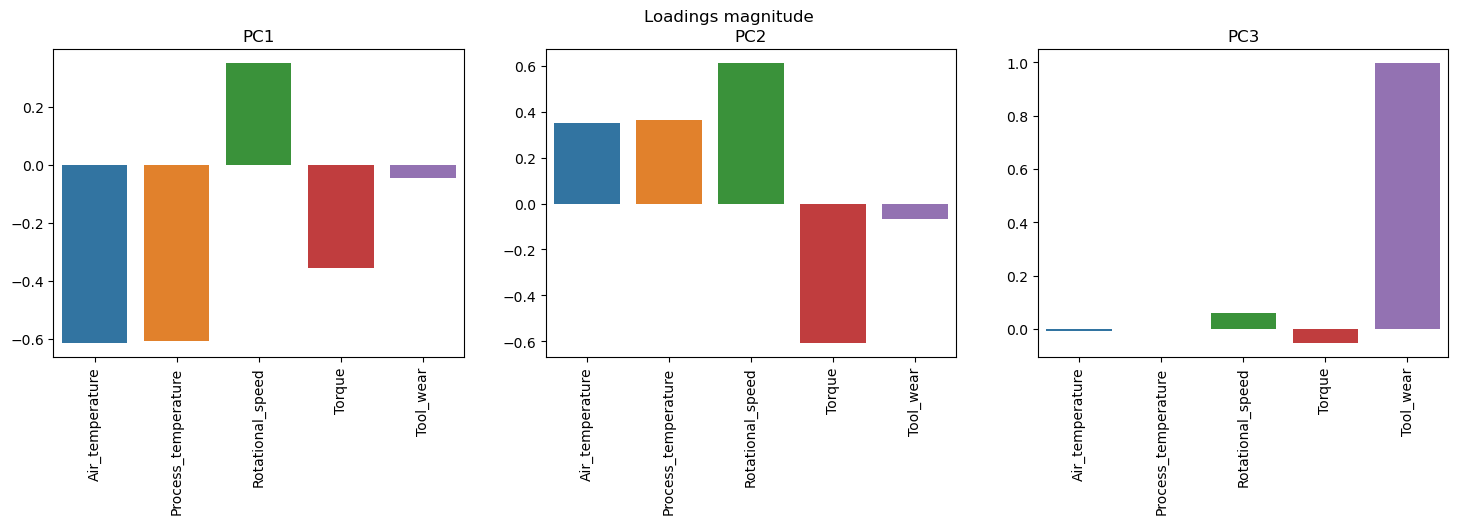

In [431]:
# PCA for Data visualization
pca3 = PCA(n_components=3)
X_pca3 = pd.DataFrame(data=pca3.fit_transform(df_main[NUMERICS_FEATURES]), columns=['PC1','PC2', 'PC3'])

# Loadings Analysis
fig, axs = plt.subplots(ncols=3, figsize=(18,4))
fig.suptitle('Loadings magnitude')
pca_loadings = pd.DataFrame(data=pca3.components_, columns=NUMERICS_FEATURES)
for j in range(3):
    ax = axs[j]
    sns.barplot(ax=ax, x=pca_loadings.columns, y=pca_loadings.values[j])
    ax.tick_params(axis='x', rotation=90)
    ax.title.set_text('PC'+str(j+1))
plt.show()  

Now, its possible see the PC1 is explain by the temperature features, the PC2 is explain by the RPM and torque features and finally the PC3 is explain by the Tool_wear.

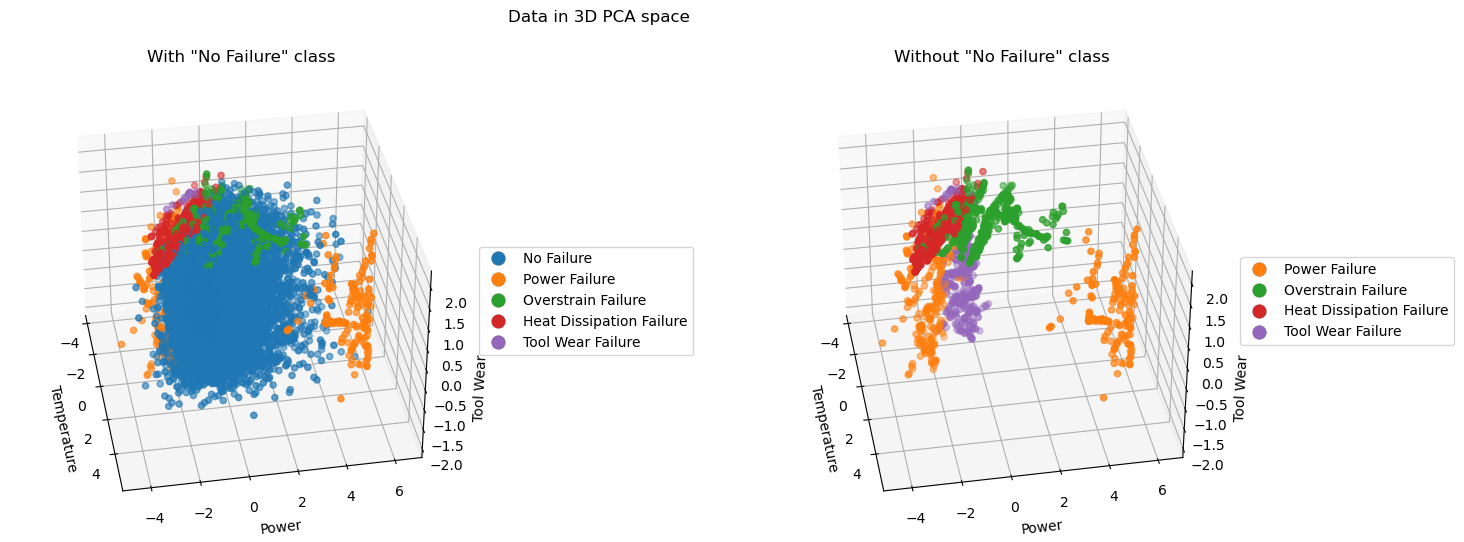

In [432]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Rename the columns the X_pca3
column_mapper = {'PC1': 'Temperature', 'PC2': 'Power', 'PC3': 'Tool Wear'}
X_pca3.rename(columns=column_mapper, inplace=True)

# Define the points color in graph
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']

# Define the labels 
label_tuples = [
    ('No Failure', 'tab:blue'),
    ('Power Failure', 'tab:orange'),
    ('Overstrain Failure', 'tab:green'),
    ('Heat Dissipation Failure', 'tab:red'),
    ('Tool Wear Failure', 'tab:purple')
]

# Create the figura of the graph
fig = plt.figure(figsize=(18, 6))
fig.suptitle('Data in 3D PCA space')

# Getting the index of the data
full_idx = X_pca3.index
idx_fail_res = df_res[df_res['Failure_type'] != 'No Failure'].index

#Plot graph
for j, idx in enumerate([full_idx, idx_fail_res]):
    ax = fig.add_subplot(1, 2, j + 1, projection='3d')

    # Scatter plot 
    scatter = ax.scatter(
        X_pca3.loc[idx, 'Temperature'],
        X_pca3.loc[idx, 'Power'],
        X_pca3.loc[idx, 'Tool Wear'],
        c=color[j]
    )

    # Configure chart labels and titles
    ax.set_xlabel('Temperature')
    ax.set_ylabel('Power')
    ax.set_zlabel('Tool Wear')
    ax.title.set_text('With' + str(j * 'out') + ' "No Failure" class')
    ax.view_init(35, -10)

    # Create personalized label
    custom_lines = [
        plt.Line2D([], [], ls='', marker='.', mec='k', mfc=c, mew=.1, ms=20)
        for c in colors[j:]
    ]
    ax.legend(custom_lines, [lt[0] for lt in label_tuples[j:]], loc='center left', bbox_to_anchor=(1.0, .5))

# Show graph
plt.show()


Interesting points with the 3d graphics analysis:
- all the flaws are at the top of the Tool_wearw;
- Power failure have influency sometimes by power and sometimes by temperature;
- Overstrain have a proportion distribution when i see temperature and power, this failure has high influence by the Tool Wear;
- TWF is influenced by temperature.


- Métrics to evaluate the model:

In [460]:
## -- Functions - ##
def get_metrics(y_true, y_pred):
    dict_metrics = {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Balanced Accuracy': balanced_accuracy_score(y_true, y_pred),
        'Macro Recall': recall_score(y_true, y_pred, average='macro'),
        'Macro Precision': precision_score(y_true, y_pred, average='macro'),
        'Macro F1': f1_score(y_true, y_pred, average='macro')
    }
    return dict_metrics

In [434]:
## To modeling i will delete the "Target" column, because in my opnion if we have "No failure" obviously we will whave "0" in 
## this column and if we have other failure typs, we will have "1" in this column consequently.

df_main.drop(['Target'], axis =1, inplace = True)

In [ ]:
NUMERICS_FEATURES = [
    'Air_temperature',
    'Process_temperature',
    'Rotational_speed',
    'Torque',
    'Tool_wear'
]

FEATURES = NUMERICS_FEATURES
TARGET = 'Failure_type'
X = df_main[FEATURES]
y = df_main[TARGET]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=2023)

preprocessor = make_column_transformer(
    (StandardScaler(), NUMERICS_FEATURES),
    (PCA(n_components=3), NUMERICS_FEATURES)
)
preprocessor



# Modeling

In [ ]:
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', DummyClassifier())
])

model_pipeline

In [447]:
params = {
    'model': [
        LogisticRegressionCV(max_iter=1_000),
        RandomForestClassifier(random_state=2023),
        GradientBoostingClassifier(random_state=2023),
        DummyClassifier()
    ] 
}

grid_search = GridSearchCV(model_pipeline, params, scoring='accuracy')
grid_search.fit(X_train, y_train)

results = pd.DataFrame(grid_search.cv_results_)

best_model_index = results['mean_test_score'].idxmax()
best_model_params = results.loc[best_model_index, 'params']
best_model_score = results.loc[best_model_index, 'mean_test_score']

print("Melhor modelo:")
print(best_model_params)
print("Pontuação de precisão do melhor modelo:")
print(best_model_score)

Melhor modelo:
{'model': RandomForestClassifier(random_state=2023)}
Pontuação de precisão do melhor modelo:
0.9734541974546091


In [451]:
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestClassifier(random_state=2023))
])

params = {
    'preprocessor__standardscaler': [StandardScaler(), PowerTransformer()],
    'model__class_weight': ['balanced'],
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [None, 5, 10],
}

grid = GridSearchCV(model_pipeline, params, cv=3, scoring='f1_macro', n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)

df_grid_results = pd.DataFrame(grid.cv_results_).sort_values('rank_test_score')
df_grid_results = df_grid_results[['param_preprocessor__standardscaler', 'param_model__class_weight', 'param_model__max_depth', 'param_model__n_estimators', 'mean_test_score', 'std_test_score']]
df_grid_results = df_grid_results.dropna()
df_grid_results = df_grid_results.reset_index(drop=True)

df_grid_results

Fitting 3 folds for each of 18 candidates, totalling 54 fits


,param_preprocessor__standardscaler,param_model__class_weight,param_model__max_depth,param_model__n_estimators,mean_test_score,std_test_score
0,PowerTransformer(),balanced,10,200,0.866115,0.010157
1,PowerTransformer(),balanced,10,100,0.865990,0.012467
2,StandardScaler(),balanced,10,100,0.865668,0.012738
3,StandardScaler(),balanced,10,200,0.865395,0.009991
4,StandardScaler(),balanced,10,300,0.864726,0.008644
5,PowerTransformer(),balanced,10,300,0.864466,0.008287
6,StandardScaler(),balanced,5,300,0.792637,0.002865
7,PowerTransformer(),balanced,5,300,0.792637,0.002865
8,StandardScaler(),balanced,5,100,0.792630,0.004581
9,PowerTransformer(),balanced,5,100,0.792408,0.004729


In [461]:
tuned_model = grid.best_estimator_

y_pred = tuned_model.predict(X_test)
get_metrics(y_test, y_pred)


{'Accuracy': 0.9809907834101382,
 'Balanced Accuracy': 0.938207320103464,
 'Macro Recall': 0.938207320103464,
 'Macro Precision': 0.9531581755911971,
 'Macro F1': 0.9454732727636618}

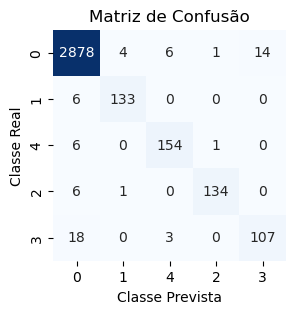

In [463]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix
confusion_mat = confusion_matrix(y_test, y_pred)

# Getting the unique class of the classification problem
classes = df_main['Failure_type'].unique()

# Plot confusion matrix
plt.figure(figsize=(3, 3))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=classes, yticklabels=classes)
plt.xlabel('Classe Prevista')
plt.ylabel('Classe Real')
plt.title('Matriz de Confusão')
plt.show()


# Deployment

In [478]:
with open('../predictive-maintenance/model.pkl', 'wb') as model_file:
    pickle.dump(tuned_model, model_file)

# Conclusion

Predictive maintenance is a strategic approach that aims to anticipate and prevent failures in equipment and machinery, increasing operational efficiency and reducing costs. Within the scope of my data science project, I had the opportunity to explore and apply this methodology through a classification algorithm developed to predict the type of failure in a specific dataset.

The dataset used in this project consists of 10,000 data points, with 14 distinct features, including information such as air temperature, process temperature, rotational speed, torque, tool wear, and a label indicating whether the machine failed or not. Although it was not originally designed for predictive maintenance purposes, I realized that it presented valuable elements for this purpose.

By applying advanced machine learning techniques, I was able to train a classification algorithm capable of predicting the type of failure in a specific process. By utilizing the parameters available in the dataset, such as tool wear, temperature, and torque, the developed model was able to provide insights into the different failure modes that could occur.

This predictive approach enables proactive decision-making regarding maintenance, allowing interventions to be made before a failure occurs. This, in turn, helps to avoid unplanned downtime and reduce costs associated with corrective maintenance.

In summary, the application of predictive maintenance through the classification algorithm developed in this project showcases my knowledge and ability to utilize advanced data science techniques to solve real-world problems. This experience strengthens my portfolio, highlighting my ability to apply data analysis and machine learning to improve operational efficiency and reduce costs in maintenance processes.